In [1]:
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize, LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.pyplot as plt
import scqubits
from tqdm import tqdm
from IPython.display import clear_output
import qutip
from functools import partial
import matplotlib
from CoupledQuantumSystems.drive import *
from scipy.optimize import minimize

from CoupledQuantumSystems.noise import first_order_derivative,second_order_derivative,get_frequency,diel_spectral_density,one_over_f_spectral_density,T_phi
from CoupledQuantumSystems.IFQ import gfIFQ
from CoupledQuantumSystems.evo import ODEsolve_and_post_process

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

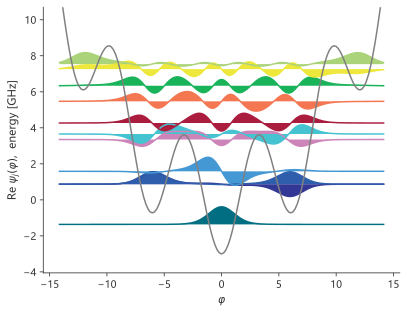

In [2]:
EJ = 3
EJoverEC = 6
EJoverEL = 25
EC = EJ / EJoverEC
EL = EJ / EJoverEL

qbt = gfIFQ(EJ = EJ,EC = EC, EL = EL, flux = 0,truncated_dim=20)
e_ops = [qutip.basis(qbt.truncated_dim, i)*qutip.basis(qbt.truncated_dim, i).dag() for i in range(10)]

element = np.abs(qbt.fluxonium.matrixelement_table('n_operator',evals_count=3)[1,2]) 
freq = (qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]) * 2 * np.pi
qbt.fluxonium.plot_wavefunction(which=[0,1,2,3,4,5,6,7,8,9,10])


[ 1.89480470e+02  1.64392566e+00 -3.92754235e-04]


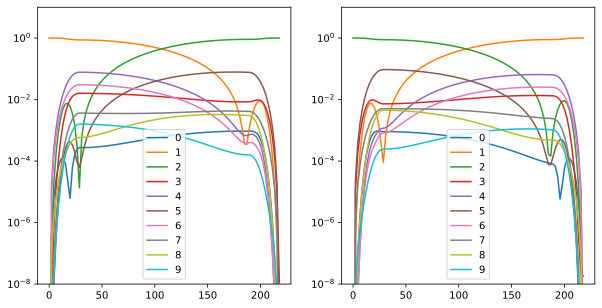

(8.639168513902007e-08, 9.151998159317998e-08)


In [ ]:
def objective(x):
    t_tot = x[0]
    amp = x[1]
    w_d = x[2]
    tlist = np.linspace(0, t_tot*1.15, 100)

    initial_states = [qutip.basis(qbt.truncated_dim, 1),qutip.basis(qbt.truncated_dim, 2)]

    drive_terms = [
            DriveTerm(
                driven_op=qutip.Qobj(
                    qbt.fluxonium.n_operator(energy_esys=True)),
                pulse_shape_func=square_pulse_with_rise_fall,
                pulse_id='pi',
                pulse_shape_args={
                    'w_d': w_d,  # Without 2pi
                    'amp': amp,  # Without 2pi
                    't_square': t_tot*0.85,
                    't_rise': t_tot*0.15
                },
            )
        ]
    results = [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=drive_terms,
                # c_ops=c_ops,
                e_ops=e_ops,
                ) for i in range(len(initial_states))]

    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1]))
    one_minus_pop1 = np.abs(1- (results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop1))
    return one_minus_pop2 + one_minus_pop1

t_tot = 200
amp = np.pi/element/t_tot/3.1415/2
w_d = qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]
initial_guess =[t_tot,amp,w_d]
result = minimize(objective, initial_guess, method='Nelder-Mead')

[ 1.61308884e+00 -9.85564889e-08]


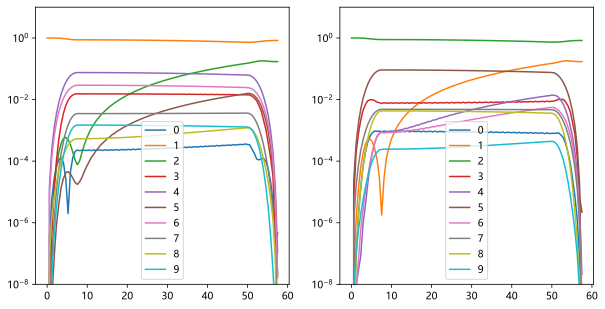

(0.8289599433226944, 0.8289599489500857)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.6579198922760605
        x: [ 1.613e+00 -1.086e-07]
      nit: 17
      jac: [ 5.735e-05 -3.280e-04]
     nfev: 108
     njev: 36
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def objective(x):
    t_tot = 50
    amp = x[0]
    w_d = x[1]
    tlist = np.linspace(0, t_tot*1.15, 100)

    initial_states = [qutip.basis(qbt.truncated_dim, 1),qutip.basis(qbt.truncated_dim, 2)]

    drive_terms = [
            DriveTerm(
                driven_op=qutip.Qobj(
                    qbt.fluxonium.n_operator(energy_esys=True)),
                pulse_shape_func=square_pulse_with_rise_fall,
                pulse_id='pi',
                pulse_shape_args={
                    'w_d': w_d,  # Without 2pi
                    'amp': amp,  # Without 2pi
                    't_square': t_tot*0.85,
                    't_rise': t_tot*0.15
                },
            )
        ]
    results = [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=drive_terms,
                # c_ops=c_ops,
                e_ops=e_ops,
                ) for i in range(len(initial_states))]

    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1]))
    one_minus_pop1 = np.abs(1- (results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop1))
    return one_minus_pop2 + one_minus_pop1

t_tot  = 50
amp = np.pi/element/t_tot/3.1415/2
w_d = qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]
initial_guess =[amp,w_d]
result = minimize(objective, initial_guess, method='l-bfgs-b')
result

[ 5.44837563e-01 -1.01119958e-08]


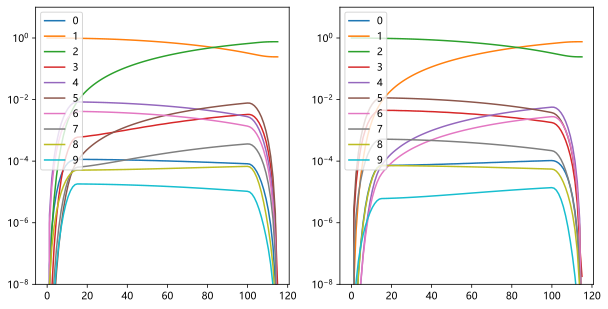

(0.24407165769902617, 0.24407166837158678)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.48814332607210087
        x: [ 5.448e-01 -2.011e-08]
      nit: 22
      jac: [-2.257e-05 -1.488e-04]
     nfev: 111
     njev: 37
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def objective(x):
    t_tot = 100
    amp = x[0]
    w_d = x[1]
    tlist = np.linspace(0, t_tot*1.15, 100)

    initial_states = [qutip.basis(qbt.truncated_dim, 1),qutip.basis(qbt.truncated_dim, 2)]

    drive_terms = [
            DriveTerm(
                driven_op=qutip.Qobj(
                    qbt.fluxonium.n_operator(energy_esys=True)),
                pulse_shape_func=square_pulse_with_rise_fall,
                pulse_id='pi',
                pulse_shape_args={
                    'w_d': w_d,  # Without 2pi
                    'amp': amp,  # Without 2pi
                    't_square': t_tot*0.85,
                    't_rise': t_tot*0.15
                },
            )
        ]
    results = [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=drive_terms,
                # c_ops=c_ops,
                e_ops=e_ops,
                ) for i in range(len(initial_states))]

    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1]))
    one_minus_pop1 = np.abs(1- (results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop1))
    return one_minus_pop2 + one_minus_pop1
t_tot  = 100
amp = np.pi/element/t_tot/3.1415/2
w_d = qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]
initial_guess =[amp,w_d]
result = minimize(objective, initial_guess, method='l-bfgs-b')
result

[0.56679488 0.00057526]


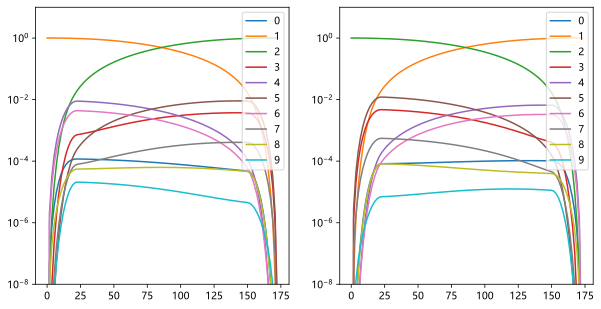

(7.597430740080569e-08, 7.251727063284363e-08)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.4847774831849847e-07
        x: [ 5.668e-01  5.752e-04]
      nit: 23
      jac: [ 8.427e-06  1.383e-03]
     nfev: 114
     njev: 38
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [14]:
def objective(x):
    t_tot = 150
    amp = x[0]
    w_d = x[1]
    tlist = np.linspace(0, t_tot*1.15, 100)

    initial_states = [qutip.basis(qbt.truncated_dim, 1),qutip.basis(qbt.truncated_dim, 2)]

    drive_terms = [
            DriveTerm(
                driven_op=qutip.Qobj(
                    qbt.fluxonium.n_operator(energy_esys=True)),
                pulse_shape_func=square_pulse_with_rise_fall,
                pulse_id='pi',
                pulse_shape_args={
                    'w_d': w_d,  # Without 2pi
                    'amp': amp,  # Without 2pi
                    't_square': t_tot*0.85,
                    't_rise': t_tot*0.15
                },
            )
        ]
    results = [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=drive_terms,
                # c_ops=c_ops,
                e_ops=e_ops,
                ) for i in range(len(initial_states))]

    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1]))
    one_minus_pop1 = np.abs(1- (results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop1))
    return one_minus_pop2 + one_minus_pop1
t_tot  = 150
amp = np.pi/element/t_tot/3.1415/2
w_d = qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]
initial_guess =[amp,w_d]
result = minimize(objective, initial_guess, method='l-bfgs-b')
result

[0.73787315 0.00118147]


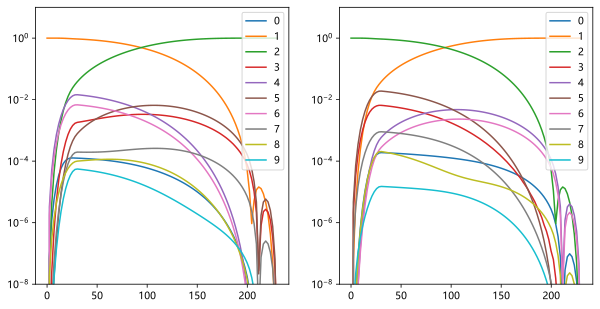

(7.443816796293135e-08, 7.405451096786919e-08)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.4849388785265205e-07
        x: [ 7.379e-01  1.181e-03]
      nit: 20
      jac: [-1.332e-07 -1.209e-04]
     nfev: 84
     njev: 28
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def objective(x):
    t_tot = 200
    amp = x[0]
    w_d = x[1]
    tlist = np.linspace(0, t_tot*1.15, 100)

    initial_states = [qutip.basis(qbt.truncated_dim, 1),qutip.basis(qbt.truncated_dim, 2)]

    drive_terms = [
            DriveTerm(
                driven_op=qutip.Qobj(
                    qbt.fluxonium.n_operator(energy_esys=True)),
                pulse_shape_func=square_pulse_with_rise_fall,
                pulse_id='pi',
                pulse_shape_args={
                    'w_d': w_d,  # Without 2pi
                    'amp': amp,  # Without 2pi
                    't_square': t_tot*0.85,
                    't_rise': t_tot*0.15
                },
            )
        ]
    results = [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=drive_terms,
                # c_ops=c_ops,
                e_ops=e_ops,
                ) for i in range(len(initial_states))]

    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1]))
    one_minus_pop1 = np.abs(1- (results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop1))
    return one_minus_pop2 + one_minus_pop1
t_tot  = 200
amp = np.pi/element/t_tot/3.1415/2
w_d = qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]
initial_guess =[amp,w_d]
result = minimize(objective, initial_guess, method='l-bfgs-b')

result

[0.40904068 0.00213598]


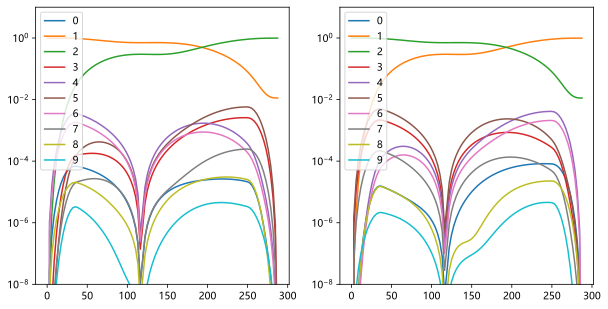

(0.011223386812331038, 0.011223389899830627)


  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.02244677671265438
        x: [ 4.090e-01  2.136e-03]
      nit: 20
      jac: [-3.129e-05 -4.927e-05]
     nfev: 108
     njev: 36
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

In [ ]:
def objective(x):
    t_tot = 250
    amp = x[0]
    w_d = x[1]
    tlist = np.linspace(0, t_tot*1.15, 100)

    initial_states = [qutip.basis(qbt.truncated_dim, 1),qutip.basis(qbt.truncated_dim, 2)]

    drive_terms = [
            DriveTerm(
                driven_op=qutip.Qobj(
                    qbt.fluxonium.n_operator(energy_esys=True)),
                pulse_shape_func=square_pulse_with_rise_fall,
                pulse_id='pi',
                pulse_shape_args={
                    'w_d': w_d,  # Without 2pi
                    'amp': amp,  # Without 2pi
                    't_square': t_tot*0.85,
                    't_rise': t_tot*0.15
                },
            )
        ]
    results = [ODEsolve_and_post_process(
                y0=initial_states[i],
                tlist=tlist,
                static_hamiltonian=qbt.diag_hamiltonian,
                drive_terms=drive_terms,
                # c_ops=c_ops,
                e_ops=e_ops,
                ) for i in range(len(initial_states))]

    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1]))
    one_minus_pop1 = np.abs(1- (results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop1))
    return one_minus_pop2 + one_minus_pop1
t_tot  = 250
amp = np.pi/element/t_tot/3.1415/2
w_d = qbt.fluxonium.eigenvals()[2]-qbt.fluxonium.eigenvals()[1]
initial_guess =[amp,w_d]
result = minimize(objective, initial_guess, method='l-bfgs-b')

result

In [20]:
0.5668 * 2* np.pi

3.561309432109389

In [ ]:
t_tot  = 150
amp = 5.668e-01  
w_d = 5.752e-04
tlist = np.linspace(0, t_tot*1.15, 100)

state_0_dressed = qutip.basis(qbt.truncated_dim, 1)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

temp_in_mK = 20
Q_cap = 1e5
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        Q_cap,
                        one_over_f_flux_noise_amplitude) + qbt.get_Tphi_c_ops(one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(qbt.truncated_dim)]


def truncate_to_computational(state,i,j):
    if state.isket:
        state = qutip.ket2dm(state)
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)

def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)

results = [ODEsolve_and_post_process(
            y0=initial_states[i],
            tlist=tlist,
            static_hamiltonian=qbt.diag_hamiltonian,
            drive_terms=[
                        DriveTerm(
                            driven_op=qutip.Qobj(
                                qbt.fluxonium.n_operator(energy_esys=True)),
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id='pi',
                            pulse_shape_args={
                                'w_d': w_d,  # Without 2pi
                                'amp': amp,  # Without 2pi
                                't_square': t_tot*0.85,
                                't_rise': t_tot*0.15
                            },
                        )
                    ],
            c_ops=c_ops,
            e_ops=e_ops,
            ) for i in range(len(initial_states))]
dms = [truncate_to_computational(result.states[-1], 1,2) for result in results]
def objective_function(phase):
    return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
opt_result

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.00011195567147781471
       x: [ 3.302e+00]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 18

In [26]:
1- 0.00011195567147781471

0.9998880443285222

In [27]:
def get_e_pop_j(state, j):
    return qutip.expect(qutip.ket2dm(qutip.basis(qbt.truncated_dim,j)), state)

np.mean([get_e_pop_j(result.states[-1], 0) for result in results])

0.0002832179471582073

In [28]:
1 - np.mean([get_e_pop_j(result.states[-1], 0) for result in results])- np.mean([get_e_pop_j(result.states[-1], 1) for result in results])- np.mean([get_e_pop_j(result.states[-1], 2) for result in results])

0.0002454061618593073

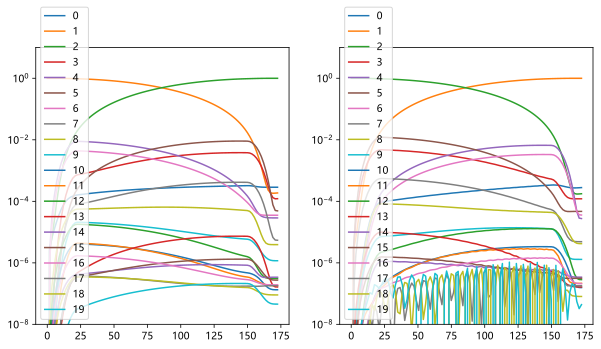

In [19]:
fig, axes = plt.subplots(1,2,figsize = (10,5))
for i, exp in enumerate(results[0].expect):
    axes[0].plot(tlist,exp,label= f"{i}")
for i, exp in enumerate(results[1].expect):
    axes[1].plot(tlist,exp,label= f"{i}")
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-8,1e1)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e1)
plt.show()

In [25]:
results_no_cops  = [ODEsolve_and_post_process(
            y0=initial_states[i],
            tlist=tlist,
            static_hamiltonian=qbt.diag_hamiltonian,
            drive_terms=[
                        DriveTerm(
                            driven_op=qutip.Qobj(
                                qbt.fluxonium.n_operator(energy_esys=True)),
                            pulse_shape_func=square_pulse_with_rise_fall,
                            pulse_id='pi',
                            pulse_shape_args={
                                'w_d': w_d,  # Without 2pi
                                'amp': amp,  # Without 2pi
                                't_square': t_tot*0.85,
                                't_rise': t_tot*0.15
                            },
                        )
                    ],
            # c_ops=c_ops,
            e_ops=e_ops,
            ) for i in range(len(initial_states))]

dms = [truncate_to_computational(result.states[-1], 1,2) for result in results_no_cops]
def objective_function(phase):
    return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
opt_result

 Total run time:   0.53s*] Elapsed 0.53s / Remaining 00:00:00:00
 Total run time:   0.52s*] Elapsed 0.52s / Remaining 00:00:00:00[*********98%***********] Elapsed 0.51s / Remaining 00:00:00:00
 Total run time:   0.53s*] Elapsed 0.53s / Remaining 00:00:00:00
 Total run time:   0.55s*] Elapsed 0.54s / Remaining 00:00:00:00
 Total run time:   0.53s*] Elapsed 0.53s / Remaining 00:00:00:00
 Total run time:   0.55s*] Elapsed 0.55s / Remaining 00:00:00:00


 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 2.826824330171007e-10
       x: [ 3.302e+00]
     nit: 2
   direc: [[ 1.000e+00]]
    nfev: 18

In [22]:
colors = ['#4999c3','#d5373d','black','#9467bd','green','#e377c2','#17becf','tab:olive','grey','grey','grey','grey','grey','grey','grey']
z_order_dict = {
    1:-10,
    0:10,
    2:9,
    3:12,
    4:13,
    5:11,
    6:15,
    7: -20,
    8:-30,9:-31,10:-32,11:-33,12:-34
}

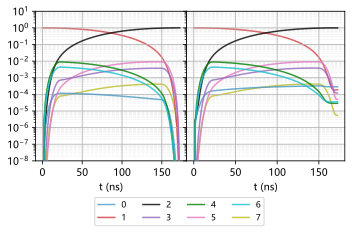

In [23]:
import matplotlib.ticker as ticker

fig = plt.figure(figsize=(5, 3.2)) 
gs0 = fig.add_gridspec(nrows=1, ncols=1,left=0.1, right=0.52,bottom=0.32,top = 0.97)
gs1 = fig.add_gridspec(nrows=1, ncols=1,left=0.52, right=0.96,bottom=0.32,top = 0.97)

axes = [fig.add_subplot(gs0[0]),  fig.add_subplot(gs1[0])]

j = 0
# for i in range(len(e_ops)):
for i in range(8):
    alpha = 0.8
    if colors[i] == 'grey':
        alpha = 0.3
    if i <= 7: 
        label= rf"$\langle{i}\rangle$"
    else:
        label = None
    axes[0].plot(tlist,results_no_cops[j].expect[i],label= f"{i}",color=colors[i],alpha=alpha,zorder = z_order_dict[i])

    axes[1].plot(tlist,results[j].expect[i],color=colors[i],alpha=alpha,zorder = z_order_dict[i])

for ax in axes:
    ax.set_yscale('log')

    # Major and minor ticks for logarithmic scale
    ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))  # Set major ticks
    ax.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs='auto', numticks=10))  # Set minor ticks

    ax.grid(which='major', linestyle='-')  # Solid grid lines for major ticks
    ax.grid(which='minor', linestyle='--',alpha=0.2)  # Dashed grid lines for minor ticks

    ax.set_ylim(1e-8, 1e1)
    ax.set_xlabel('t (ns)')

axes[1].set_ylabel('')
axes[1].set_yticklabels([])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:8], labels[:8], loc='lower center',ncol = 4, fontsize='small', bbox_to_anchor=(0.5, 0.02))

fig.savefig('X_gate_simple.pdf')